# This notebook presents a baseline cnn model trained with and without data augmentation to see the differences



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/classify_stanford_dogs/blob/master/baseline.ipynb)

First, import the relevant libraries : 
First, we will try this with only 4 different classes and import the relevant librairies

In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
import os 
import shutil
import matplotlib.pyplot as plt 
from matplotlib import image
import numpy as np
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [10]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  !ls /content/gdrive/My\ Drive/Formation-OC/P5-Stackoverflow
  root_dir = '/content/gdrive/My Drive/Formation-OC/P6-Images/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'

  baseline_species = os.listdir(input_dir+'baseline_inputs/train')

  #my script
  !ls gdrive/MyDrive/Formation-OC/P6-Images/
else:
  print('Not running on CoLab')
  #my script
  root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P6/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

Running on CoLab
Mounted at /content/gdrive
function.py  inputs  P5_presentation.pptx  pngs
inputs	models	P6-presentation.pptx  pngs


In [ ]:
species = os.listdir(input_dir+'Images/')
species = [specie for specie in species if specie !='.DS_Store']
print('There are {} different species'.format(len(species)))

There are 120 different species


## Lets create a repertory called baseline_inputs to get only 4 different races :

In [12]:
def create_baseline_train_val_rep(species, input_dir, validation_split=0.3, random_seed = 42 ):
    '''Create repertories and put train and validation into them. Careful, the images must already be in separate folders into an Image rep.
    input_dir (str): the path where to create the baseline directory
    species (list(str)): the list of directories to take and split into train and validation
    validation split (float, optional): proportion of img to take as validation. Default is 0.3.'''
    
    assert os.path.exists(input_dir), 'input_dir doesnot exists'
    img_dir = input_dir+'Images/'
    baseline_dir = input_dir+'baseline_inputs/'
    
    assert os.path.exists(img_dir), 'every images must be into a Images directory in the input_dir'
    for specie in species :
        assert os.path.exists(img_dir+specie), '{} folder doesnot exists'.format(specie)
    
    assert not os.path.exists(baseline_dir), 'baseline_inputs already exists, consider removing it first'
    
    np.random.seed(random_seed)
    os.mkdir(baseline_dir)
    os.mkdir(baseline_dir+'train')
    os.mkdir(baseline_dir+'validation')
    for specie in species:
        os.mkdir(baseline_dir+'train/'+specie)
        os.mkdir(baseline_dir+'validation/'+specie)
        
        img_names = os.listdir(img_dir+specie)
        img_train, img_validation = train_test_split(img_names, test_size=validation_split, random_state=random_seed)
      
        print('For class {}, there is {} training images and {} validation images'.format(specie.split('-')[1],len(img_train),len(img_validation)))
        for img in img_train :
            shutil.copy(img_dir+specie+'/'+img, baseline_dir+'train/'+specie )
        for img in img_validation :
            shutil.copy(img_dir+specie+'/'+img, baseline_dir+'validation/'+specie )

In [8]:
np.random.seed(42) # To ensure re-usability
baseline_dir = input_dir+'baseline_inputs/'
baseline_species = np.random.choice(species,4)
baseline_dir = input_dir+'baseline_inputs/'
print(baseline_species)

NameError: ignored

In [ ]:
if os.path.exists(baseline_dir):
    print('baseline_inputs exists, removing it')
    shutil.rmtree(baseline_dir)
    create_baseline_train_val_rep(baseline_species, input_dir, validation_split=0.2, random_seed = 42 )
else :
    print('baseline_inputs doesnot exists')
    create_baseline_train_val_rep(baseline_species, input_dir, validation_split=0.2, random_seed = 42 )


baseline_inputs exists, removing it
For class toy_poodle, there is 120 training images and 31 validation images
For class miniature_poodle, there is 124 training images and 31 validation images
For class Great_Dane, there is 124 training images and 32 validation images
For class English_foxhound, there is 125 training images and 32 validation images


### Lets display the _idx_ img of each specie

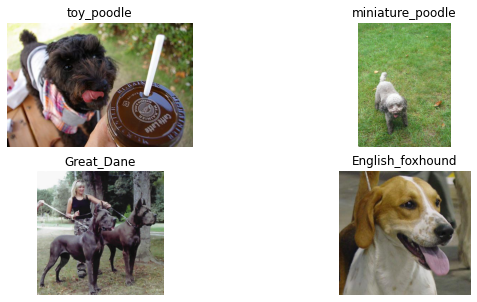

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=False)

axes = axes.flatten()
for idx in range(len(baseline_species)):
    img = image.imread(baseline_dir+'train/'+baseline_species[idx]+'/'+os.listdir(baseline_dir+'train/'+baseline_species[idx])[0])
    axes[idx].imshow(img)
    #axes[idx].imshow()
    axes[idx].set_title(baseline_species[idx].split('-')[1])
    axes[idx].axis('off')

plt.show()

## Now lets instanciate an image augmentation object from tf.keras to understand its behavior

In [15]:
def display_aug(generator, img_path, target_size = (150,150), nb_img=4):
    assert nb_img < 7, 'please keep nb_img under 7'
    assert len(target_size)==2, 'Target size must be of (height, length)'

    img = load_img(img_path, grayscale=False, target_size=target_size)
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    fig, axes = plt.subplots(1, nb_img, figsize=(int(3*nb_img),int(5*nb_img)), sharex=False)

    axes = axes.flatten()

    idx = 0
    for batch in generator.flow(x, batch_size=1):
        axes[idx].imshow(array_to_img(batch[0]))
        axes[idx].axis('off')
        idx += 1
        if idx > nb_img-1:
            break
    plt.show()

## Lets build two imagedatagenerator : one will be used for data augmentation later and the other which doesnot do data augmentation. 
## The latter will be used for both training and validation to create a baseline model

In [6]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


Using the augmentation


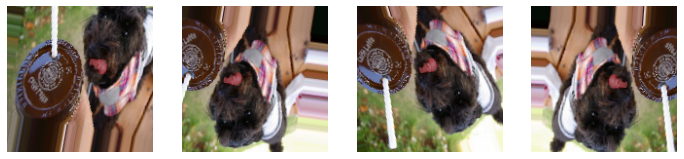

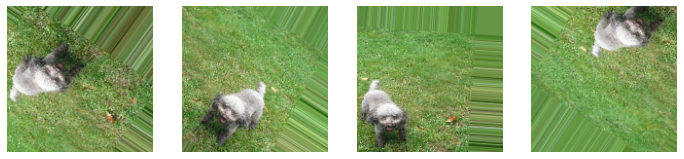

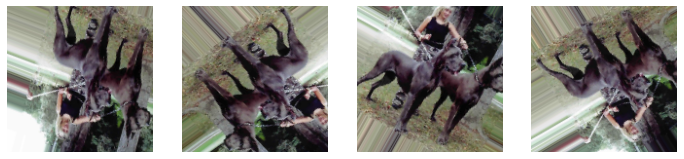

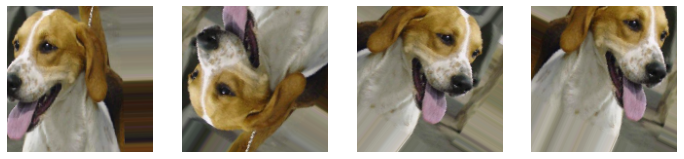

Using the no augmentation 


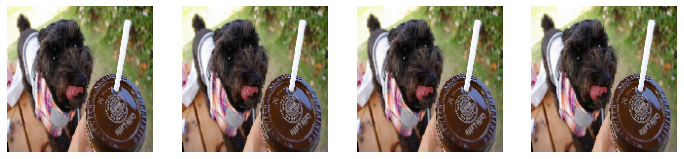

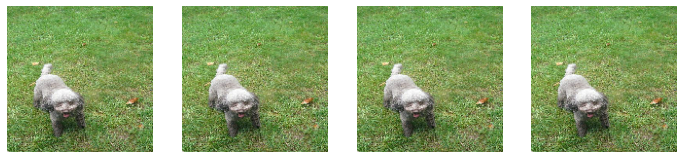

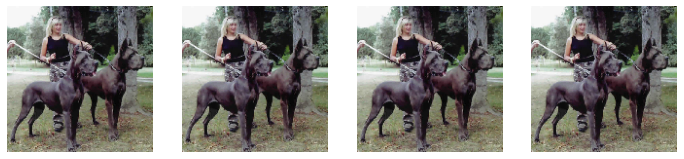

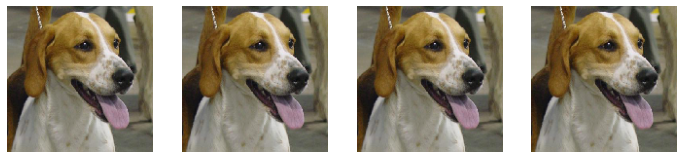

In [16]:
idx = 0
print('Using the augmentation')
for specie in baseline_species:
    display_aug(train_datagen, baseline_dir+'train/'+specie+'/'+os.listdir(baseline_dir+'train/'+specie)[idx])
    
print('Using the no augmentation ')
for specie in baseline_species:
    display_aug(test_datagen, baseline_dir+'train/'+specie+'/'+os.listdir(baseline_dir+'train/'+specie)[idx])
    

## Lets build and train the first simple CNN model

In [ ]:
# the model so far outputs 3D feature maps (height, width, features)

input_shape = (150,150,3)
batch_size = 16

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))


# converts our 3D feature maps to 1D feature vectors
model.add(tf.keras.layers.Flatten())  
model.add(tf.keras.layers.Dense(10,activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(baseline_species),activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                800010    
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 44        
Total params: 800,950
Trainable params: 800,950
Non-trainable params: 0
_________________________________________________________________


### For the moment, lets use the same generator, without data augmentation

In [ ]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = test_datagen.flow_from_directory(baseline_dir+'train/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(baseline_dir+'validation/',
                                                        target_size=input_shape[:-1],
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        seed= 42)

Found 493 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


In [ ]:
def get_callbacks(monitor='val_loss',save_name=None,patience=8):
    '''Returns the wanted callbacks to save models and avoid overfitting.
    monitor (str, optional): the monitor to check for the early stopping. Default is 'val_loss'
    save_name (str, optional): if not None, uses modelcheckpoint and saves checkpoints at the save_name. Default is None.
    patience (int, optional): number of epoch to wait for improvment of monitor. Default is 8.'''
    if save_name :
        return [tf.keras.callbacks.ModelCheckpoint(filepath=save_name,
                                                   monitor=monitor, 
                                                   save_best_only=True,
                                                   verbose=0),
                tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                 patience=patience,
                                                 restore_best_weights=True)
                ]
    else:
        return [tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                 patience=patience,
                                                 restore_best_weights=True)
                ]


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

H = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=5,
                        callbacks=get_callbacks()
                        )

Epoch 1/5
30/30 [==============================] - 31s 1s/step - loss: 1.3856 - accuracy: 0.2516 - val_loss: 1.3861 - val_accuracy: 0.2589
Epoch 2/5
30/30 [==============================] - 31s 1s/step - loss: 1.3661 - accuracy: 0.3208 - val_loss: 1.3448 - val_accuracy: 0.3393
Epoch 3/5
30/30 [==============================] - 39s 1s/step - loss: 1.3608 - accuracy: 0.2917 - val_loss: 1.3862 - val_accuracy: 0.2589
Epoch 4/5
30/30 [==============================] - 43s 1s/step - loss: 1.3860 - accuracy: 0.2321 - val_loss: 1.3862 - val_accuracy: 0.2321
Epoch 5/5
30/30 [==============================] - 31s 1s/step - loss: 1.3861 - accuracy: 0.2453 - val_loss: 1.3862 - val_accuracy: 0.2589


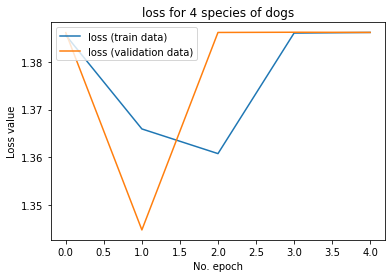

In [ ]:
plt.plot(H.history['loss'], label='loss (train data)')
plt.plot(H.history['val_loss'], label='loss (validation data)')
plt.title('loss for 4 species of dogs')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

In [35]:
def create_cnn(input_shape, output_length,
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = None, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = False, activation_FC = 'relu'
               ):
  '''Create a CNN based model is model_transfert is None. Else, the model_transfert is used for feature extraction. 
  If reducing is not False, nb_FC_neurons must be multiple of 2**nb_FC_layer '''

  assert input_shape[-1] == 3, 'For the moment only models with rgb input is dealt'
  #for shape in input_shape[:-1] : assert shape % 2**nb_cnn ==  0 , 'Each dimension of input must be a multiple of 2**nb_cnn'
  if reducing : assert nb_FC_neurons % 2**nb_FC_layer == 0 , 'If reducing, nb_FC_neurons must be multiple of 2**nb_FC_layer '

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape, name = 'Input_layer'))

  if model_transfert == None: 
    for cnn in range(nb_cnn):
      model.add(tf.keras.layers.Conv2D( filters = nb_filters, kernel_size = (3,3), padding='same', activation = activation_cnn, name ='Conv2D_'+str(cnn+1) ))
      model.add(tf.keras.layers.MaxPooling2D( pool_size=(2, 2), name ='MaxPool_'+str(cnn+1)))
  else : 
    model.add(model_transfert)
  
  model.add(tf.keras.layers.Flatten())

  if reducing : 
    for FC in range(nb_FC_layer):
      model.add(tf.keras.layers.Dense(nb_FC_neurons/2**FC, activation= activation_FC, name='FC_layer_'+str(FC+1)))
  else:
    for FC in range(nb_FC_layer):
      model.add(tf.keras.layers.Dense(nb_FC_neurons, activation= activation_FC, name='FC_layer_'+str(FC+1)))
  
  model.add(tf.keras.layers.Dense(output_length, activation = 'softmax'))

  return model

In [38]:
input_shape = (150,150, 3)
batch_size = 16

model = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = None, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu'
               )

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 75, 75, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 37, 37, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)            

In [40]:
base_model_VGG19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape, classes=len(baseline_species))

80142336/80134624 [==============================] - 1s 0us/step


In [42]:
base_model_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [43]:
model = create_cnn(input_shape=input_shape, output_length=len(baseline_species),
               nb_cnn=3, nb_filters = 64, activation_cnn = 'relu', 
               model_transfert = base_model_VGG19, fine_tune = False, 
               nb_FC_layer = 3, nb_FC_neurons = 512, reducing = True, activation_FC = 'relu'
               )

In [44]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
FC_layer_1 (Dense)           (None, 512)               4194816   
_________________________________________________________________
FC_layer_2 (Dense)           (None, 256)               131328    
_________________________________________________________________
FC_layer_3 (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 24,383,940
Trainable params: 24,383,940
Non-trainable params: 0
__________________________________________

In [ ]:
# the model so far outputs 3D feature maps (height, width, features)

input_shape = (150,150,3)
batch_size = 16

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# converts our 3D feature maps to 1D feature vectors
model.add(tf.keras.layers.Flatten())  
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(baseline_species),activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18496)           